<a href="https://colab.research.google.com/github/thefenriswolf/FutureLab/blob/main/FutureLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libary Imports

In this field, we import all the pieces of software we are going to use.

**This code MUST be run be run before anything else!!!**

In [1]:
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# check for active GPU
print(tf.test.gpu_device_name())
print(tf.__version__)

/device:GPU:0
2.5.0


# Activation Functions

In [ ]:
# rectified linear function
def relu(x):
  if x > 0:
    return x
  else: return 0

def relu6(x):
  if x > 6:
    return 6
  elif x > 0:
    return x
  else: return 0

def sigmoid(x):
  return 1/(1+np.exp(x*(-1)))

##### Task 1:
Use the code **below** to plot the activation functions defined **above**

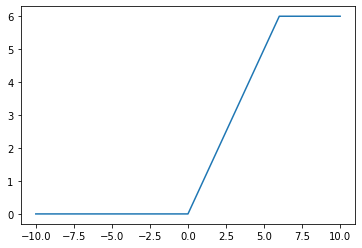

In [ ]:
# define a series of inputs
series_in = [x for x in range(-10, 11)]

# calculate outputs for our inputs
series_out = [relu6(x) for x in series_in] # <-- Name of activation funtction goes here

# line plot of raw inputs to rectified outputs
plt.plot(series_in, series_out)
plt.show()

# Regression


## Manual regression

Let's say we gathered some data:
Body height and Ring size of a few people and we want to predict the Ring size by putting it in relation to someones body height.


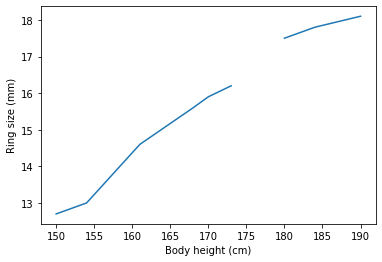

In [ ]:
data = np.array([
    [150.0, 12.7],
    [154.0, 13.0],
    [161.0, 14.6],
    [168.0, 15.6],
    [170.0, 15.9],
    [173.0, 16.2],
    [175.0, np.nan],
    [180, 17.5],
    [184.0, 17.8],
    [190, 18.1],
])
x, y = data.T
plt.xlabel("Body height (cm)")
plt.ylabel("Ring size (mm)")
plt.plot(x,y)
plt.show()

## Linear Interpolation

We could of course just draw a straight line to complete the plot, but let's use a tiny bit of math first.
To use linear interpolation we just need to know the x and y values of 2 points on a graph and we can interpolate a point in between.

Formula: $$\widehat{y(x)}=y_{i}+\frac{(y_{i+1}-y_{i})(x-x_{i})}{x_{i+1}-x_{i}}$$

16.57142857142857


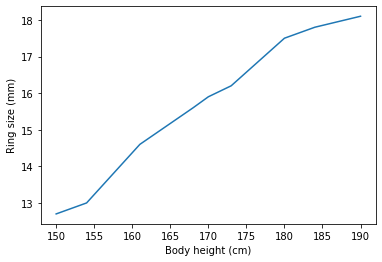

In [ ]:
x_prev=173.0
x_post=180
y_prev=16.2
y_post=17.5
x_missing=175.0

# lin_interpolation takes the x and y values of two points and the x value of a point in between those points.
def lin_interpolation(x_prev, x_post, y_prev, y_post, x_missing):
 return y_prev + (((y_post-y_prev)*(x_missing-x_prev))/(x_post-x_prev))

y_missing=lin_interpolation(x_prev, x_post, y_prev, y_post, x_missing)
print(y_missing)

data = np.array([
    [150.0, 12.7],
    [154.0, 13.0],
    [161.0, 14.6],
    [168.0, 15.6],
    [170.0, 15.9],
    [173.0, 16.2],
    [175.0, y_missing],
    [180, 17.5],
    [184.0, 17.8],
    [190, 18.1],
])
x, y = data.T
plt.xlabel("Body height (cm)")
plt.ylabel("Ring size (mm)")
plt.plot(x,y)
plt.show()

## ML Regression
To use Machine Learning for Regression our data ought to be of a more complex nature and we need a larger sample size for it to work properly.

The [publicly available dataset](https://doi.org/10.1016/j.dss.2009.05.016) we are going to use contains *11* physiochemical properties of *4897* wine samples and its perceived quality.

### Dataset import
The first step is always to clean and import the data we are going to use.
Our data comes as a ready to use CSV file (plaintext spreadsheet format) and requires very little cleanup.

In [ ]:
# We'll pull our dataset from this study: https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377?via%3Dihub
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# The dataset comes with headers, but it's always a good idea to write them down for reference
column_names = ["fixed acidity", "volatile acidity", "citric acid",
                "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide",
                "density", "pH", "sulphates", "alcohol", "quality"]

# We use pandas read_csv() Function to parse the file and convert it to a pandas dataframe
raw_dataset = pd.read_csv(url, header='infer',
                          sep=';', skipinitialspace=True)
# url: dataset source
# header='infer': autodetect first line as header
# sep=';': values in the dataset are separated by a semicolon
# skipinitialspace=True: ignore extra spaces if there are any

# Let's take a look at out data and check if importing worked as expected
# head(): shows the 'head' (first few lines) of any file or dataframe, the opposite of head is 'tail'
#raw_dataset.head()
raw_dataset.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


#### Dataset sanity check

We have a very clean dataset on our hands.
Usually we'd have to spend considerable time cleaning up our dataset for proper use.
**Always** check your dataset for missing values, inconsistencies and other irregularities, as it saves you lots of time later in the development process.

In [ ]:
# Check for unknown values and sum them up
raw_dataset.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

#### Dataset split

We want most of our data for training the model and smaller amount for testing its capabilities.
In this case we go for a 80:20 ratio.  

In [ ]:
# Never modify your raw data, always create a copy to work on!
wdataset = raw_dataset

# Now let's split our dataset in a test and train dataset
# We'll use the train dataset to (hopefully) teach our model.
# The test dataset will be useful after training to validate that the training processes worked as expected.

train_dataset = wdataset.sample(frac=0.8, random_state=0)
# sample() takes n random items (80% in this case) from a list or sequence

test_dataset = wdataset.drop(train_dataset.index)
# Now we create a dataset and delete any item that sample() picked so we are left with our unique test_dataset

# Always check if a manipulation did what you expected it to do.
train_dataset.shape

# 3918 is 80.00816826628548% of 4897, so we successfuly split our dataset in training and testing data using a 80:20 ratio.

(3918, 12)

### Single Input 
Just like in the manual regression example above, we have two inputs. In this case we want to predict the amount of alcohol contained by establishing a relationship to the pH level.

#### Label creation

In [ ]:
# First we create a work copy so we don't have to modify our raw data.
si_train_features = train_dataset.copy()
si_test_features = test_dataset.copy()


# Now we filter out the parameter we want our model to predict. Here I settle on 'alcohol' but you can choose any label you like.
# Of course we have to do this in both datasets.
si_train_labels = si_train_features.pop('alcohol')
si_test_labels = si_test_features.pop('alcohol')

# Let's take a look at our data again.
train_dataset.describe().transpose()[['mean', 'std']]

# Upon closer inspection we see that the values are in a mean rage (0.04-137.7).
# This rather large range might "confuse" our model, so we have to apply some 'normalization'

,mean,std
fixed acidity,6.858754,0.855479
volatile acidity,0.278278,0.100173
citric acid,0.334722,0.122170
residual sugar,6.380028,5.057262
chlorides,0.045709,0.022408
free sulfur dioxide,35.172282,17.139453
total sulfur dioxide,137.688999,42.577736
density,0.994021,0.002987
pH,3.187412,0.151155
sulphates,0.489104,0.114159


#### Model architecture

Here we define the structure of our model. We tell keras to build a sequential model (as opposed to a recurring model) and add 3 layers:
- normalization
- dense
- dense

In [ ]:
# Create a simple model for linear regression
# First we appy normalization to our feature
pH = np.array(si_train_features['pH'])
pH_normalizer = preprocessing.Normalization(input_shape=[1,])
pH_normalizer.adapt(pH)

# Then we can build our model
pH_model = tf.keras.Sequential([
    pH_normalizer,
    layers.Dense(units=1, activation='linear'),
    layers.Dense(units=1, activation='linear')
])

pH_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_10 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 2         
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________


#### Model compilation and training

In [ ]:
# Now we can tell TensorFlow to compile our model. This is necessary as TensorFlow is written in C++, we are only using Python as an abstraction on top.
# This is also the time to specify our desired optimizer and loss function.
# The learning rate defines the size of adjustment steps made during training.
pH_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

# We can let keras monitor the leaning process and stop it early if the model does not improve.
es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)

# model.fit() tells TensorFlow to start training. We just have to pass our features and labels to it.
history = pH_model.fit(
    # pass features and labels as input
    si_train_features['pH'], si_train_labels,
    # how often should the model go through the dataset
    epochs=200,
    # show trainig steps
    verbose=1,
    # add early stopping capability
    callbacks=[es],
    # Calculate validation results on 90% of the training data
    validation_split = 0.9)


Epoch 1/200
13/13 [==============================] - 1s 23ms/step - loss: 10.5802 - val_loss: 10.3045
Epoch 2/200
13/13 [==============================] - 0s 27ms/step - loss: 10.3075 - val_loss: 10.1083
Epoch 3/200
13/13 [==============================] - 0s 14ms/step - loss: 10.2384 - val_loss: 9.8981
Epoch 4/200
13/13 [==============================] - 0s 14ms/step - loss: 9.9370 - val_loss: 9.6347
Epoch 5/200
13/13 [==============================] - 0s 14ms/step - loss: 9.8106 - val_loss: 9.3133
Epoch 6/200
13/13 [==============================] - 0s 15ms/step - loss: 9.3952 - val_loss: 8.9194
Epoch 7/200
13/13 [==============================] - 0s 14ms/step - loss: 8.9916 - val_loss: 8.4411
Epoch 8/200
13/13 [==============================] - 0s 14ms/step - loss: 8.4713 - val_loss: 7.8736
Epoch 9/200
13/13 [==============================] - 0s 14ms/step - loss: 7.7803 - val_loss: 7.2038
Epoch 10/200
13/13 [==============================] - 0s 14ms/step - loss: 7.2882 - val_loss: 6

#### Plot performance

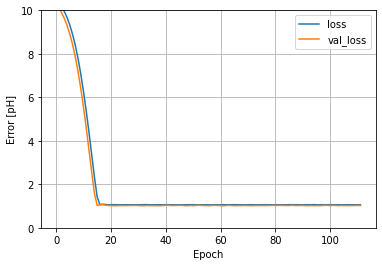

In [ ]:
# Now we can plot our models learning process
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.tail()
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [pH]')
  plt.legend()
  plt.grid(True)
plot_loss(history)


##### Task 2: 

**Go back to the Model architecture and:**
- compare the activation functions 'sigmoid', 'relu' and 'linear'
- play with different amounts of 'dense' layers

### Multi Input Model

#### Label creation

In [ ]:
mitrain_features = train_dataset.copy()
mitest_features = test_dataset.copy()

# Let's predict 'quality for a change'
mitrain_labels = mitrain_features.pop('quality')
mitest_labels = mitest_features.pop('quality')

#### Model architecture

In [ ]:
# Create a simple model for linear regression
# First we appy normalization to our whole dataset
mi = np.array(mitrain_features)
mi_normalizer = preprocessing.Normalization(input_shape=[1,])
mi_normalizer.adapt(mi)

# Then we can build our model
mi_model = tf.keras.Sequential([
    mi_normalizer,
    layers.Dense(units=1, activation='relu'),
    layers.Dense(units=1, activation='relu')
])

mi_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_15 (Normalizat (None, 11)                23        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 2         
Total params: 37
Trainable params: 14
Non-trainable params: 23
_________________________________________________________________


#### Model compilation and training

In [ ]:
mi_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')
es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)
history = mi_model.fit(
    # notice that this time we pass all labels and features to the model
    mitrain_features, mitrain_labels,
    epochs=200,
    verbose=1,
    callbacks=[es],
    validation_split = 0.9)


Epoch 1/200
13/13 [==============================] - 1s 23ms/step - loss: 4.9207 - val_loss: 3.4063
Epoch 2/200
13/13 [==============================] - 0s 14ms/step - loss: 3.0423 - val_loss: 2.0461
Epoch 3/200
13/13 [==============================] - 0s 14ms/step - loss: 1.7009 - val_loss: 0.9641
Epoch 4/200
13/13 [==============================] - 0s 14ms/step - loss: 1.0035 - val_loss: 0.6220
Epoch 5/200
13/13 [==============================] - 0s 15ms/step - loss: 0.7127 - val_loss: 0.6749
Epoch 6/200
13/13 [==============================] - 0s 14ms/step - loss: 0.7231 - val_loss: 0.6108
Epoch 7/200
13/13 [==============================] - 0s 13ms/step - loss: 0.6544 - val_loss: 0.6113
Epoch 8/200
13/13 [==============================] - 0s 14ms/step - loss: 0.6754 - val_loss: 0.5942
Epoch 9/200
13/13 [==============================] - 0s 14ms/step - loss: 0.6497 - val_loss: 0.6537
Epoch 10/200
13/13 [==============================] - 0s 14ms/step - loss: 0.6582 - val_loss: 0.5939

#### Plot performance 

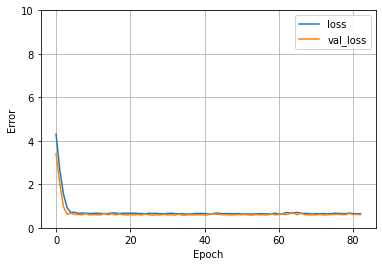

In [ ]:
# Now we can plot our models learning process
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.tail()
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
plot_loss(history)

##### Task 3: 

**Go back to the Model architecture and:**
- compare the activation functions 'sigmoid', 'relu' and 'linear'
- play with different amounts of 'dense' layers

https://www.tensorflow.org/tutorials/keras/regression

https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377?via%3Dihub


# Convolution

The TensorFlow Website has excellent tutourials on CNN's

Check out this beginner tutourial:

https://www.tensorflow.org/hub/tutorials/tf2_image_retraining






![](https://cdn02.nintendo-europe.com/media/images/10_share_images/games_15/nintendo_switch_download_software_1/H2x1_NSwitchDS_HereBeDragons.jpg)

